# Probabilistic Programming - 2

## Monte Carlo sampling

In this notebook, we are exploring a more complex problem set using Monte Carlo sampling, namely mixture modeling. It will show you how to extend the sampling procedure to the multivariate case.

### Preliminaries

- Goal 
  - Write a Monte Carlo sampling procedure for a 2-dimensional mixture model.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Tutorials using [Turing.jl](https://turing.ml/dev/tutorials/0-introduction/)
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

## Mixture modeling

We will first generate a synthetic data set to play around. This will let us focus on the data-generating process and on the point that a good model should follow the data-generating process.

In [1]:
# using Pkg;Pkg.activate("workspace");Pkg.instantiate()

In [2]:
using Logging; disable_logging(LogLevel(0))
using Distributions
using StatsPlots
using LaTeXStrings

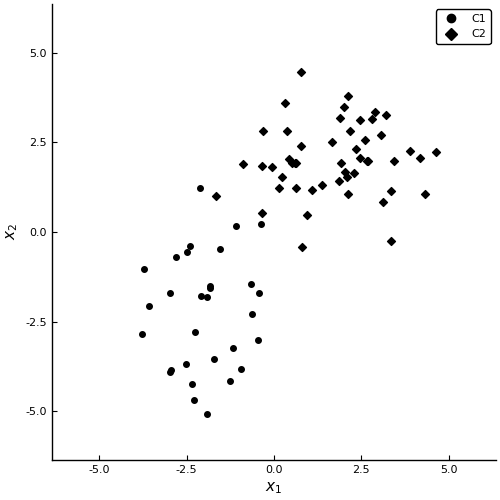

In [29]:
# Sample size
N1 = 30
N2 = 50

# Parameters for each cluster
μ1 = [-2., -2.]
Σ1 = [1.0 0.0; 0.0 3.0]
μ2 = [+2., +2.]
Σ2 = [3.0 0.0; 0.0 1.0]

function generate_data(μ_1::Array{Float64,1}, μ_2::Array{Float64,1}, Σ_1::Array{Float64,2}, Σ_2::Array{Float64,2}; num_samples1=10, num_samples2=10)
    "Generate data from a 2-dimensional mixture model"
    
    # Cluster 1
    X1 = rand(MvNormal(μ_1, Σ_1), num_samples1)
    
    # Cluster 2
    X2 = rand(MvNormal(μ_2, Σ_2), num_samples2)
    
    # Concatenate clusters
    X = [X1'; X2']
    
    # Keep track of cluster membership
    y = [ones(num_samples1,); 2*ones(num_samples2,)]
    
    return X, y
end

# Generate data
observations, cluster = generate_data(μ1, μ2, Σ1, Σ2, num_samples1=N1, num_samples2=N2)

# Visualization
scatter(observations[cluster .== 1, 1], observations[cluster .== 1, 2], marker=:circle, color="black", label="C1")
scatter!(observations[cluster .== 2, 1], observations[cluster .== 2, 2], 
         marker=:diamond,
         color="black", 
         label="C2", 
         xlabel=L"$x_1$", 
         ylabel=L"$x_2$", 
         xlim=[-6, 6], 
         ylim=[-6, 6], 
         size=(500,500),
         grid=false)

### Monte Carlo Sampling

First, we will import Turing.jl and the package containing the sampler. The script being included contains utility functions, important for plotting and diagnosing.

In [30]:
using Turing
using MCMCChains
Turing.setadbackend(:forward_diff)
include("../scripts/pp-2.jl");

We will now define the Gaussian Mixture model.

In [32]:
@model GaussianMixtureModel(X, m1, m2) = begin
    "2-dimensional Gaussian mixture model with spherical covariances"
    
    # Data shape
    N, D = size(X)

    # Draw the mean for cluster 1 [2x1 vector]
    μ1 ~ MvNormal(m1, 10*[1. 0.; 0. 1.])
    
    # Draw the mean for cluster 2 [2x1 vector]
    μ2 ~ MvNormal(m2, 10*[1. 0; 0. 1.])
    
    # Concatenate means [2x2 matrix]
    μ = [μ1 μ2]
    
    # Probability of belonging to each cluster [2x1 vector]
    w = [0.5, 0.5]
    
    # Preallocate assignment vector [Nx1 vector]
    k = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by w
        k[i] ~ Categorical(w)
        
        # Data point x[i] follows a normal distribution, with mean indexed by the assignment variable k[i]
        X[i,:] ~ MvNormal(μ[:, k[i]], [1. 0; 0. 1.])
    end
    
    # Return the assignments
    return k
end

# Set priors
m1 = [-2, -2]
m2 = [+2, +2]

# Create an instance of a model, using the observations
model = GaussianMixtureModel(observations, m1, m2);

We now have a data set and a model. To arrive at class assignments for each data point, we need to perform inference. As stated before, there are two main schools of thought in Bayesian inference: Monte Carlo sampling and variational approximations. Below, we will use a particular form of Monte Carlo sampling, called Gibbs sampling.

In [6]:
# Construct Gibbs sampler
sampler = Gibbs(PG(20, :k), HMC(0.1, 2, :μ1, :μ2))

# Start sampling
chain = sample(model, sampler, 200);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:08


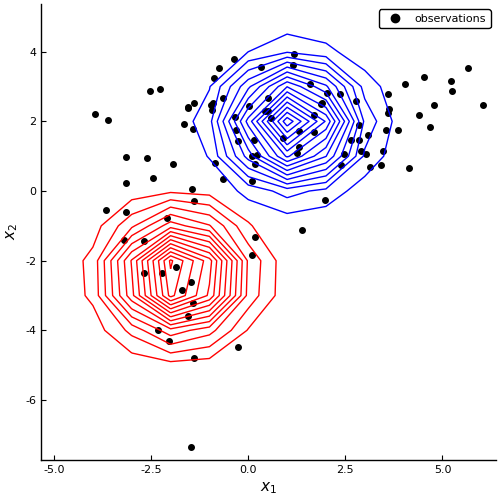

In [7]:
# Extract the means over the MCMC chains
μ1_hat = mean_chain(chain, :μ1)
μ2_hat = mean_chain(chain, :μ2)

# Plot data and overlay estimated posterior probabilities
plot_posteriors(observations, μ1_hat, μ2_hat, x1=range(-5, stop=5), x2=range(-5, stop=5))

Let's take a closer look at the chain. 

In [8]:
describe(chain[[:μ1, :μ2]])

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std      │ naive_se  │ mcse      │ ess     │
│     │ Symbol     │ Float64  │ Float64  │ Float64   │ Float64   │ Any     │
├─────┼────────────┼──────────┼──────────┼───────────┼───────────┼─────────┤
│ 1   │ μ1[1]      │ -1.80848 │ 0.236316 │ 0.0167101 │ 0.0354844 │ 30.4717 │
│ 2   │ μ1[2]      │ -2.43737 │ 0.354622 │ 0.0250756 │ 0.172573  │ 4.10755 │
│ 3   │ μ2[1]      │ 1.13082  │ 0.181222 │ 0.0128143 │ 0.0261234 │ 11.5548 │
│ 4   │ μ2[2]      │ 1.93522  │ 0.118681 │ 0.008392  │ 0.0139779 │ 253.124 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ μ1[1]      │ -2.42631 │ -1.93338 │ -1.79025 │ -1.64085 │ -1.43688 │
│ 2   │ μ1[2]      │ -3.21315 │ -2.68109 │ -2.44043 │ -2.17

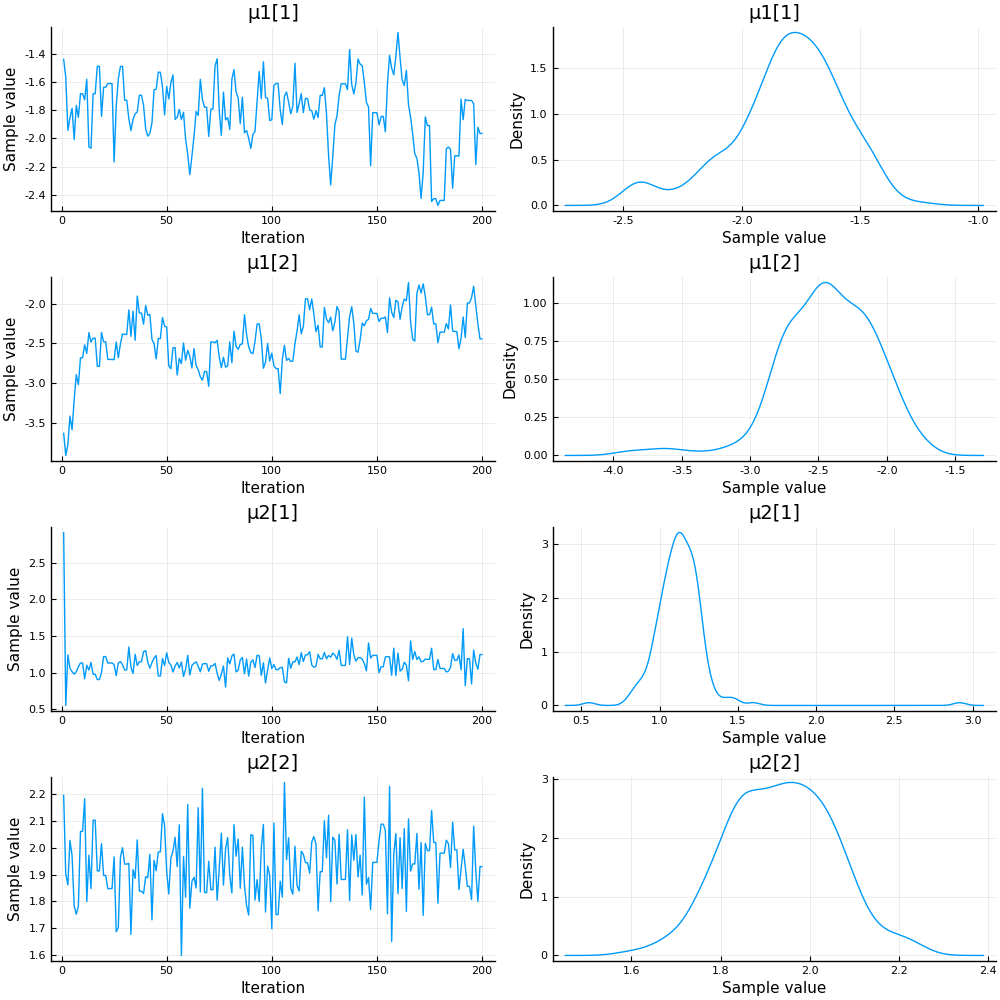

In [9]:
plot(chain[[:μ1, :μ2]])

### Model improvement: covariance matrices

We modeled the data with spherical Gaussians. But the data doesn't really look spherical; the cluster plot showed that quite a few samples are not covered by the two Gaussians. This suggests that we should estimate the covariance matrices as well. 

A variance parameter is a strictly positive number and is captured with a Gamma distrbution. A covariance matrix is a positive-definite matrix and can be captured with a Wishart distribution. The [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution) is the natural multivariate extension of the Gamma distribution:

$$ \mathcal{W}_p(C \mid V, n) = \frac{1}{2^{np/2} \ |V|^{n/2} \ \Gamma_p(n/2)} |C|^{(n-p-1)/2} \exp(-\text{tr}(V^{-1}C)/2)$$

where $p$ is the dimensionality of the matrix-variate, $n$ is the degrees of freedom and $V$ is a scale matrix. $\Gamma_p$ is a multivariate gamma function (continuous version of the factorial function).

It is relatively straightforward to add two Wishart priors to the model:

In [33]:
@model GaussianMixtureModel(X, m1, m2, S1, S2) = begin
    "2-dimensional Gaussian mixture model with free covariances"
    
    # Data shape
    N, D = size(X)

    # Draw means for each cluster [2x1 vector]
    μ1 ~ MvNormal(m1, 10*[1. 0.; 0. 1.])
    μ2 ~ MvNormal(m2, 10*[1. 0.; 0. 1.])
    
    # Draw a covariance matrix for each cluster [2x2 matrix]
    Σ1 ~ Wishart(2, S1)
    Σ2 ~ Wishart(2, S2)
    
    # Concatenate parameters to allow for indexing
    μ = [μ1 μ2]
    Σ = cat(Σ1, Σ2, dims=3)
    
    # Probability of belonging to each cluster [2x1 vector]
    w = [0.5, 0.5]
    
    # Preallocate assignment vector [Nx1 vector]
    k = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by w
        k[i] ~ Categorical(w)
        
        # Data point x[i] follows a normal distribution, with mean and covariance indexed by k[i]
        X[i,:] ~ MvNormal(μ[:, k[i]], Σ[:,:, k[i]])
    end
    
    # Return the assignments
    return k
end

# Set prior means
m1 = [-1, -1]
m2 = [+1, +1]

# Set prior covariances
S1 = [1. 0.;0. 1.]
S2 = [1. 0.;0. 1.]

# Create an instance of a model, using the observations
model = GaussianMixtureModel(observations, m1, m2, S1, S2);

We'll have to extend the sampler as well. For now, we'll include $\Sigma1$ and $\Sigma2$ in the Hamiltonian MC procedure.

In [35]:
# Construct Gibbs sampler
sampler = Gibbs(PG(20, :k), HMC(0.1, 2, :μ1, :μ2, :Σ1, :Σ2))

# Start sampling
chain = sample(model, sampler, 1000);

Progress: 100%|█████████████████████████████████████████| Time: 0:11:45


Let's extract the sample averages for the means and covariances of the clusters.

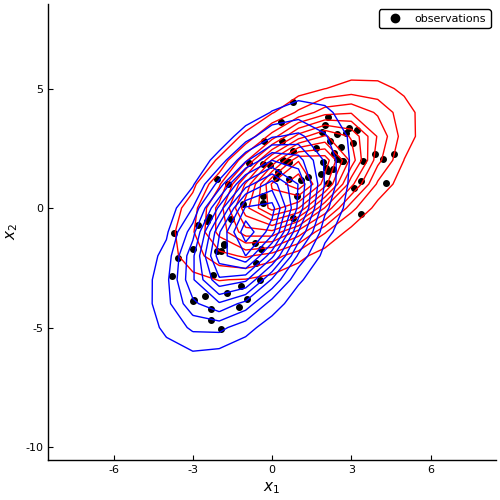

In [36]:
# Extract the means over the MCMC chains
μ1_hat = mean_chain(chain, :μ1)
μ2_hat = mean_chain(chain, :μ2)
Σ1_hat = reshape(mean_chain(chain, :Σ1), (2,2))
Σ2_hat = reshape(mean_chain(chain, :Σ2), (2,2))

# Plot data and overlay estimated posterior probabilities
plot_posteriors(observations, μ1_hat, μ2_hat, Σ1=Σ1_hat, Σ2=Σ2_hat, x1=range(-8, stop=8), x2=range(-10, stop=8))

Notice that we've improved coverage of all the points, but the fit is still not perfect.

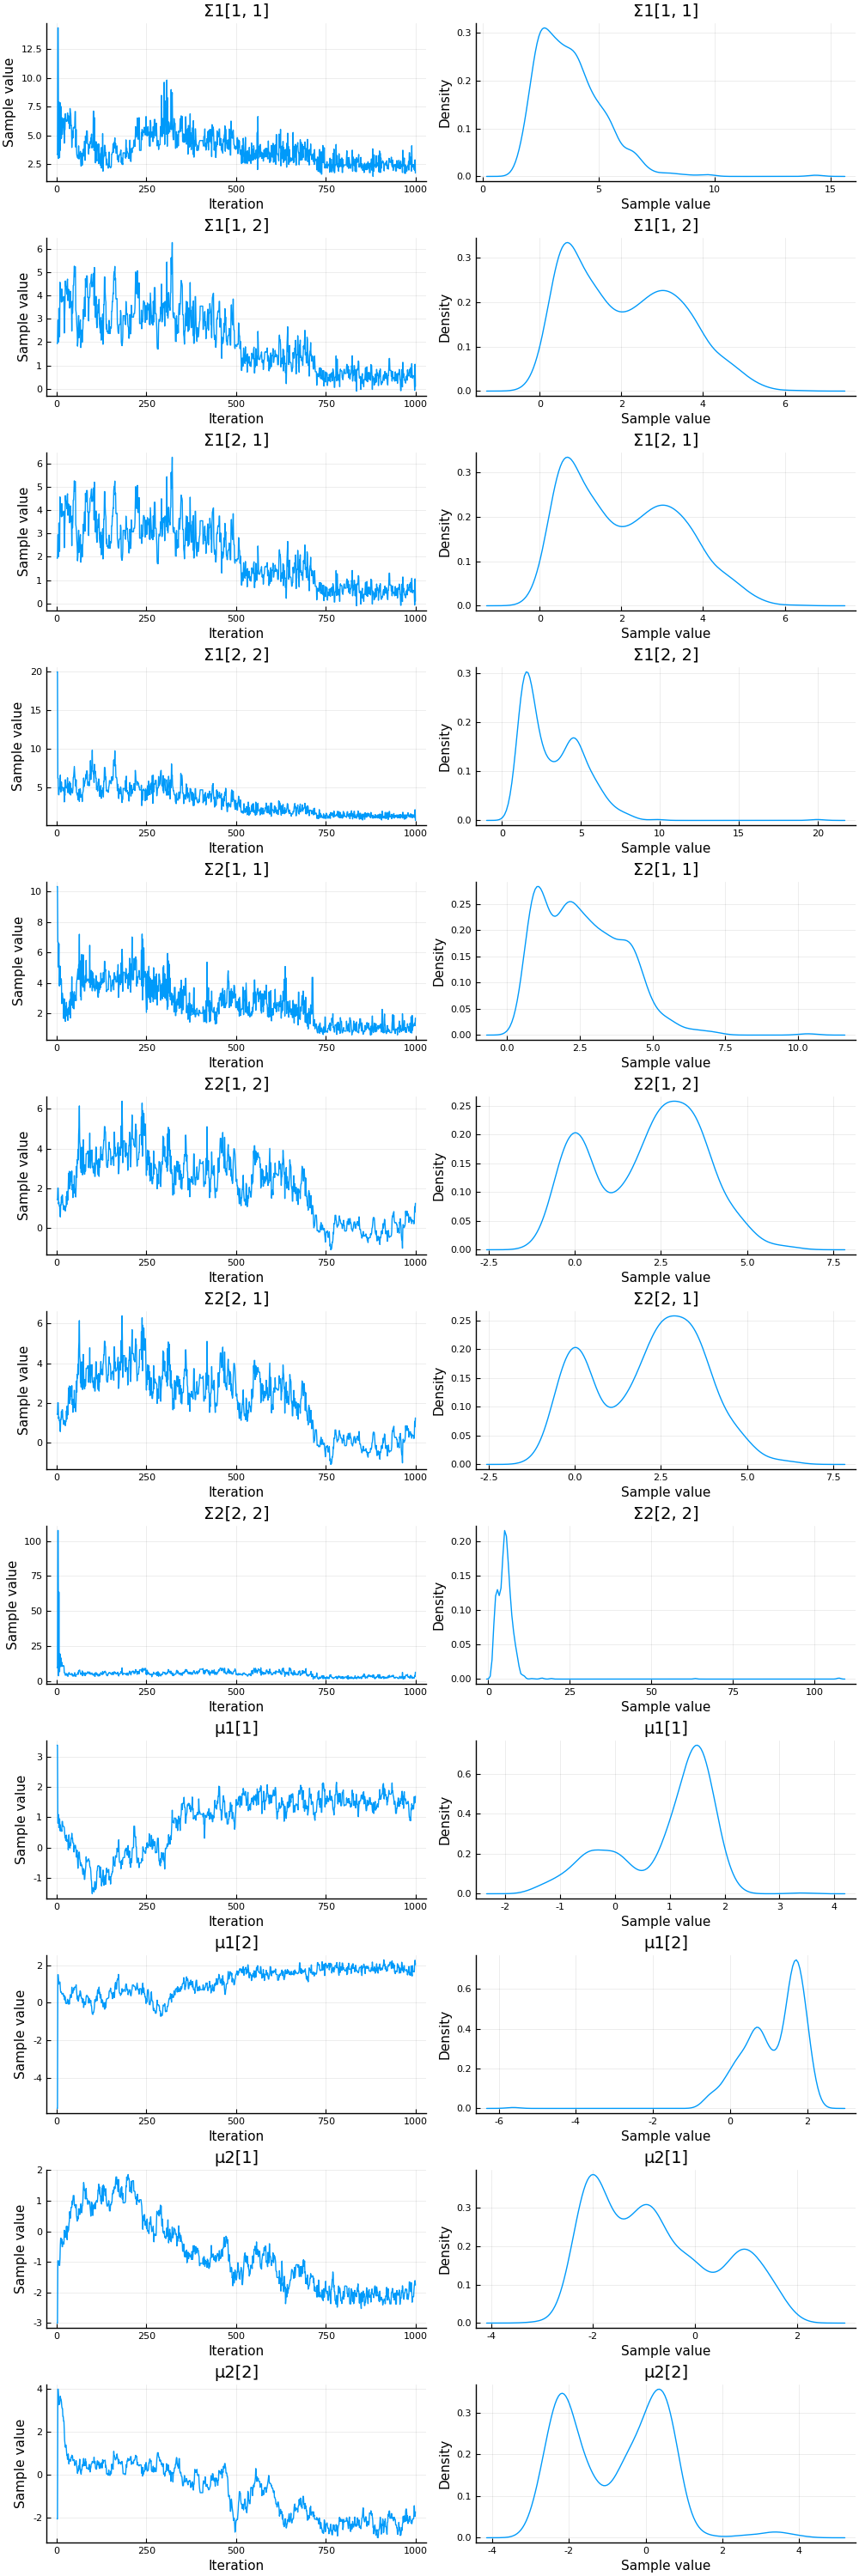

In [37]:
plot(chain[[:μ1, :Σ1, :μ2, :Σ2]])

### Model improvement: cluster proportions

In [38]:
@model GaussianMixtureModel(X, m1, m2, S1, S2, a) = begin
    "2-dimensional Gaussian mixture model with free covariances"
    
    # Data shape
    N, D = size(X)

    # Draw means for each cluster [2x1 vector]
    μ1 ~ MvNormal(m1, 10*[1. 0.; 0. 1.])
    μ2 ~ MvNormal(m2, 10*[1. 0.; 0. 1.])
    
    # Draw a covariance matrix for each cluster [2x2 matrix]
    Σ1 ~ Wishart(2, S1)
    Σ2 ~ Wishart(2, S2)
    
    # Draw a proportion 
    π ~ Dirichlet(a)
    
    # Concatenate parameters to allow for indexing
    μ = [μ1 μ2]
    Σ = cat(Σ1, Σ2, dims=3)
    
    # Preallocate assignment vector [Nx1 vector]
    k = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by w
        k[i] ~ Categorical(π)
        
        # Data point x[i] follows a normal distribution, with mean and covariance indexed by k[i]
        X[i,:] ~ MvNormal(μ[:, k[i]], Σ[:,:, k[i]])
    end
    
    # Return the assignments
    return k
end

# Set prior means
m1 = [-1, -1]
m2 = [+1, +1]

# Set prior covariances
S1 = [1. 0.;0. 1.]
S2 = [1. 0.;0. 1.]

# Set prior proportions
a = [1., 1.]

# Create an instance of a model, using the observations
model = GaussianMixtureModel(observations, m1, m2, S1, S2, a);

Start sampler, with pi under the Hamiltonian MC

In [39]:
# Construct Gibbs sampler
sampler = Gibbs(PG(20, :k), HMC(0.1, 2, :μ1, :μ2, :Σ1, :Σ2, :π))

# Start sampling
chain = sample(model, sampler, 1000);

Progress: 100%|█████████████████████████████████████████| Time: 0:07:01


Extract parameters from the chains

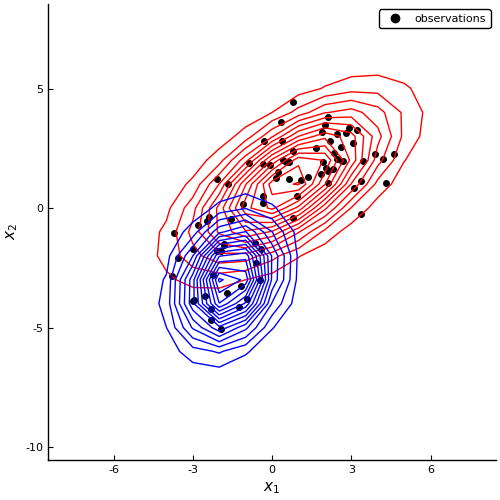

In [40]:
# Extract the means over the MCMC chains
π_hat = mean_chain(chain, :π)
μ1_hat = mean_chain(chain, :μ1)
μ2_hat = mean_chain(chain, :μ2)
Σ1_hat = reshape(mean_chain(chain, :Σ1), (2,2))
Σ2_hat = reshape(mean_chain(chain, :Σ2), (2,2))

# Plot data and overlay estimated posterior probabilities
plot_posteriors(observations, μ1_hat, μ2_hat, Σ1=Σ1_hat, Σ2=Σ2_hat, π=π_hat, x1=range(-8, stop=8), x2=range(-10, stop=8))

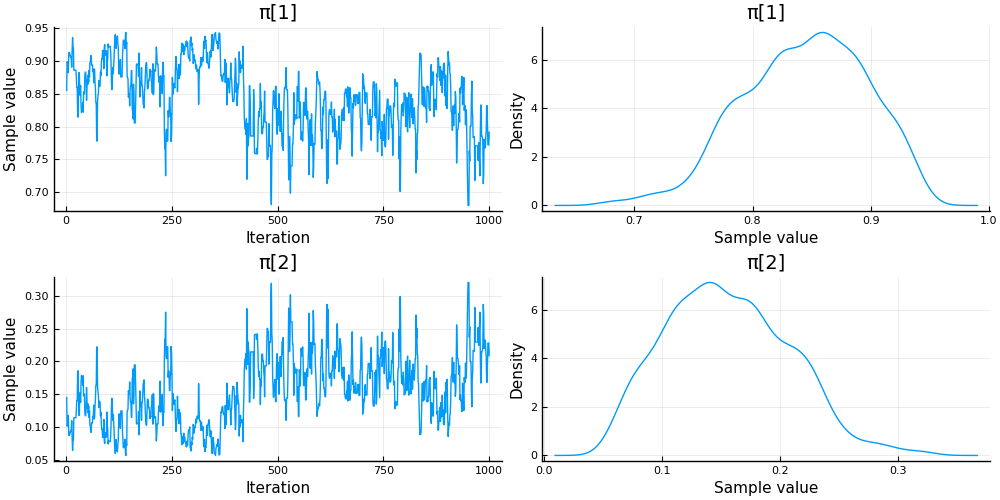

In [41]:
plot(chain[:π])

### Assignment 1: 3 clusters

Can you change the model to work with 3 clusters instead of 2?

### Optional Assignment: Dirichlet Process

Are we sure we need 3 clusters to model this data? Maybe we need 4? Or 5? 

There is a way to automatically determine the number of clusters in the data. 